In [225]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_prominences, find_peaks
import warnings
from sklearn.model_selection import KFold
import random
import os
from src.utils import data_load
import datetime
import pandas as pd
import scipy.stats as stats
from fastdtw import fastdtw
from scipy.signal import find_peaks, savgol_filter
import copy


In [270]:
oura_sleep_list = ['rmssd', 'awake', 'midpoint_at_delta', 'onset_latency', 'hr_lowest', 'light', 'rem']
oura_activity_list = ['average_met', 'rest', 'non_wear']
oura_readiness_list = ['score_temperature']
features = oura_sleep_list + oura_activity_list + oura_readiness_list
results_folder = '/repos/Delivery-Readiness/TiVaCPD/TiVaCPD/out2/bump_correlation_features_zscore_normalized_scheduled_missingness5/'

In [271]:
subjective_data = {'birth', 'quick_activities', 'surveys', }
survey_data = data_load(data_keys=subjective_data, wave=8)

In [272]:
survey_data['surveys'].title.unique()

array(['Global survey', 'Daily survey', 'Engagement survey',
       'Pilot survey', 'Baseline survey', 'COVID-19 Baseline survey',
       'Maternal Social Support Index', 'Healthcare Utilization survey',
       'PUQE', 'Pain Interference survey',
       'Sleep Related Impairment survey', 'Emotional Support survey',
       'COVID Infection survey', 'Fatigue survey', 'Personality survey',
       'Severe Symptom and Complication survey', 'Perinatal PTSD'],
      dtype=object)

In [273]:
survey_data['quick_activities'].stream.unique()

array(['Cognition Quick Activity', 'Stress Quick Activity',
       'Energy Quick Activity', 'Mood Quick Activity',
       'Anxiety Quick Activity'], dtype=object)

In [274]:
daily_survey = survey_data['surveys'][survey_data['surveys']['title'] == 'Daily survey']
birth_df = survey_data['birth']


In [275]:
daily_survey.head()

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,record_id,date
1,2331077,2504,6,Daily survey,2022-10-20 00:00:00,2022-10-20 01:00:00,2022-10-20 23:00:00,2022-10-20 00:27:43.729658,2022-10-20 20:20:33.872122,85,Right now do you feel in control?,0,direct_294,2022-10-20
3,2298517,2504,6,Daily survey,2022-10-15 00:00:00,2022-10-15 01:00:00,2022-10-15 23:00:00,2022-10-15 00:20:56.935588,2022-10-15 18:40:34.608998,85,Right now do you feel in control?,0,direct_294,2022-10-15
4,2632030,2504,6,Daily survey,2022-12-14 00:00:00,2022-12-14 01:00:00,2022-12-14 23:00:00,2022-12-13 23:25:51.807284,2022-12-14 20:00:19.053001,85,Right now do you feel in control?,0,direct_294,2022-12-14
7,2167910,2528,6,Daily survey,2022-09-26 00:00:00,2022-09-26 01:00:00,2022-09-26 23:00:00,2022-09-26 00:22:24.480772,2022-09-26 12:31:37.595408,85,Right now do you feel in control?,0,direct_215,2022-09-26
11,2173900,2528,6,Daily survey,2022-09-27 00:00:00,2022-09-27 01:00:00,2022-09-27 23:00:00,2022-09-27 00:20:16.976543,2022-09-27 09:22:17.605743,85,Right now do you feel in control?,0,direct_215,2022-09-27


In [276]:
daily_survey.dtypes

id                int64
user_id           int64
survey_id         int64
title            object
event_date       object
from             object
to               object
created_at       object
updated_at       object
question_id       int64
question_text    object
answer_text      object
record_id        object
date             object
dtype: object

In [277]:
def fill_in_missing_dates(df, date_col_name = 'date', start_date=None, end_date=None, fill_val = np.nan, date_format='%Y-%m-%d'):
    df = df.reset_index(drop=True)
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(start_date, end_date)
    df = df.reindex(idx,fill_value=fill_val)
    return df
def fill_in_missing_dates(df, date_col_name = 'date', start_date=None, end_date=None, fill_val = np.nan, date_format='%Y-%m-%d'):
    df = df.reset_index(drop=True)
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(start_date, end_date)
    df = df.reindex(idx,fill_value=fill_val)
    return df
def create_directory(directory_path):
    try:
        os.mkdir(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_path}' already exists.")
    except Exception as e:
        print(f"Error occurred: {e}")

In [265]:
len(os.listdir('/repos/Delivery-Readiness/results/cpd_results_analysis/nonscheduled'))

53

In [281]:
before_days=30
after_days=7
adherence = 0.0
max_corr_list = []
max_p_val_list = []
corr_by_categories = {}
p_val_by_categories = {}

for user_dir in os.listdir(results_folder):
    uid = int(user_dir.split('_')[-1])
    print(f'user id: {uid}')
    each_user_data = [results_folder + user_dir + '/' + f for f in os.listdir(results_folder + user_dir)]
    raw_data, corr_score, mmd_score, ensemble_score, interpretability_matrix = None, None, None, None, None
    for each_path in each_user_data:
        if "series" in each_path:
            with open(each_path, 'rb') as file:
                raw_data = pickle.load(file)
        elif "corr_score" in each_path:
            with open(each_path, 'rb') as file:
                corr_score = pickle.load(file)
        elif "mmd_score" in each_path:
            with open(each_path, 'rb') as file:
                mmd_score = pickle.load(file)
        elif "ensemble_score" in each_path:
            with open(each_path, 'rb') as file:
                ensemble_score = pickle.load(file)
        elif "interpretability_Matrix" in each_path:
            with open(each_path, 'rb') as file:
                interpretability_matrix = pickle.load(file)
    if mmd_score is not None and corr_score is not None and interpretability_matrix is not None:
        ensemble_score  = savgol_filter(np.add(abs(mmd_score), abs(corr_score)), 5, 3) 
        peaks, _ = find_peaks(ensemble_score, distance=5)
        peak_array = np.zeros_like(ensemble_score)
        peak_array[peaks] = ensemble_score[peaks]

        each_user_survey = daily_survey[daily_survey['user_id'] == uid]
        birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
        birth_date = datetime.datetime.strptime(birth_date, '%Y-%M-%d').date()
        start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
        end_date = birth_date + pd.to_timedelta(after_days, unit='d')
        each_user_survey = each_user_survey[(each_user_survey['date'] >= start_date)]
        each_user_survey = each_user_survey[(each_user_survey['date'] <= end_date)]
        
        user_dir = f'/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_{uid}/'
        create_directory(user_dir)
        corr_list = []
        pval_list = []
        all_question_ids = each_user_survey.question_id.unique()
        for each_question in all_question_ids:
            each_question_survey = each_user_survey[each_user_survey['question_id'] == each_question]
            if len(each_question_survey) >= round((before_days + after_days) * adherence):
                if len(each_question_survey.answer_text.unique()) > 1:
                    if each_question not in [81, 83]:
                        each_question_survey = each_question_survey.drop_duplicates(subset='date', keep='first')
                        each_question_survey['encoded_answer'], answer_mapping = pd.factorize(each_question_survey['answer_text'], sort=True)
                        answer_mapping_dict = dict(enumerate(answer_mapping))
                        df = fill_in_missing_dates(each_question_survey, date_col_name = 'date', start_date=start_date, end_date=end_date)
                        
                        valid_indices = ~np.isnan(peak_array) & ~np.isnan(df['encoded_answer'].values)
                        vector1_cleaned = np.array(peak_array)[valid_indices]
                        vector1_cleaned_corr = np.array(corr_score)[valid_indices]
                        vector2_cleaned = np.array(df['encoded_answer'].values)[valid_indices]
                        correlation_coefficient, p_value = stats.pearsonr(vector1_cleaned, vector2_cleaned)
                        corr_correlation_coefficient, corr_p_value = stats.pearsonr(vector1_cleaned_corr, vector2_cleaned)
                        
                        if corr_correlation_coefficient != np.nan:
                            if corr_p_value < 0.15:
                                corr_list.append(np.abs(corr_correlation_coefficient))
                                pval_list.append(corr_p_value)
                                if each_question not in corr_by_categories:
                                    corr_by_categories[each_question] = [np.abs(corr_correlation_coefficient)]
                                    p_val_by_categories[each_question] = [corr_p_value]
                                else:
                                    corr_by_categories[each_question].append(np.abs(corr_correlation_coefficient))
                                    p_val_by_categories[each_question].append(corr_p_value)

                        distance, path = fastdtw(vector1_cleaned, vector2_cleaned)
                        text_ensemble = f'. Correlation between ensemble score and answer: {round(correlation_coefficient, 2)}. '
                        text_corr = f'Correlation between corr score and answer: {round(corr_correlation_coefficient, 2)}.'
                        # print(f'DTW between ensemble score and answer: {distance}')

                        fig, ax1 = plt.subplots(figsize=(25, 5))

                        # plt.plot(mmd_score, label=f'mmd score')
                        # plt.plot(corr_score, label=f'corr score')
                        ax1.plot(list(range(-before_days, after_days)), ensemble_score, label=f'emsemble score')
                        ax1.set_xlabel('Days to Delivery')
                        ax1.set_ylabel('Ensemble Score')
                        # ax1.tick_params('y', colors='g')

                        ax2 = ax1.twinx()
                        ax2.plot(list(range(-before_days, after_days)), df['encoded_answer'].values, label=f'daily survey - qid {each_question}', marker='o', linestyle='--', color='green')
                        ax2.set_ylabel('Survey Data')
                        # ax2.tick_params('y', colors='b')
                        # plt.plot(peaks, ensemble_score[peaks], "x", markersize=10, color="purple", label=f'peaks')

                        x_min = -before_days  # changed from 0
                        x_max = after_days - 1  # changed from len(df['encoded_answer'].values) - 1

                        y_min = min(min(ensemble_score), min(answer_mapping_dict.keys()))
                        y_max = max(max(ensemble_score), max(answer_mapping_dict.keys()))
                        heatmap = plt.imshow(interpretability_matrix, cmap='seismic', aspect='auto', extent=[x_min, x_max, y_min, y_max], alpha=0.3)

                        # cbaxes = fig.add_axes([1.05, 0.15, 0.03, 0.8]) # [left, bottom, width, height]
                        cbar = plt.colorbar(heatmap, aspect=40, pad=0.02)
                        cbar.set_label('Heatmap Values')
                        plt.axvline(x=0, color='black', ls='--', label='birth date')

                        plt.legend(loc='best')
                        plt.title(f'user id: {uid}')
                        plt.xlim(-before_days, after_days -1)  # set x-axis range from -30 to 6
                        plt.ylim(min(vector2_cleaned) - 0.01, max(vector2_cleaned) + 0.01)

                        plt.tight_layout()

                        txt = str(each_question_survey.question_text.unique()[0]) + str(answer_mapping_dict)
                        plt.figtext(0.5, -0.1, txt + text_ensemble + text_corr, wrap=True, horizontalalignment='center', fontsize=12)
                        plt.savefig(f'{user_dir}qid_{each_question}', bbox_inches='tight')
                        plt.close()
        copied_corr_list = copy.deepcopy(corr_list)
        if len(corr_list) > 0:
            max_pval = 1
            while max_pval > 0.1 and len(corr_list) > 0:
                max_value = max(corr_list)
                max_pval = pval_list[corr_list.index(max_value)]
                corr_list.remove(max_value)
            if len(corr_list) > 0:
                max_index = copied_corr_list.index(max_value)
                print(f'user: {uid}, qid: {all_question_ids[max_index]}, max corr: {max_value}')
                max_corr_list.append(max_value)
                max_p_val_list.append(max_pval)


user id: 1422
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_1422/' already exists.
user id: 2530
user id: 1037
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_1037/' already exists.
user id: 2500
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_2500/' already exists.
user id: 2260
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_2260/' already exists.
user id: 2233
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_2233/' already exists.
user id: 2518
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_2518/' created successfully.
user id: 2234
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_2234/' created successfully.
user: 2234, qid: 205, max corr: 0.5620050843279724
user id: 2259
Directory '/repos/Delivery-Readiness/results/cpd_results_analysis/scheduled/user_22

In [280]:
print(corr_score)

None


In [288]:
np.mean(max_corr_list)

0.61257707845933

In [289]:
np.mean(max_p_val_list)

0.03046777565576069

No handles with labels found to put in legend.


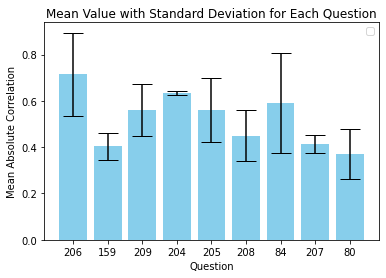

In [285]:
labels, mean_vals, std_vals = [], [], []
for key in corr_by_categories:
    if len(corr_by_categories[key]) > 1:
        labels.append(key)
        mean_vals.append(np.mean(np.array(corr_by_categories[key])))
        std_vals.append(np.std(np.array(corr_by_categories[key])))

# # Create a bar chart with error bars
# bar = plt.bar(list(range(len(labels))), mean_vals, yerr=std_vals, capsize=10, color='skyblue', labels=labels)

# # Set labels and title
# plt.xlabel('Category')
# plt.ylabel('Value')
# plt.title('Mean Value with Standard Deviation for Each Category')
# bar.bar_label(labels, label_type='center')

# plt.show()

fig, ax = plt.subplots()

p = plt.bar(list(range(len(labels))), mean_vals, yerr=std_vals, capsize=10, color='skyblue')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Question')
ax.set_ylabel('Mean Absolute Correlation')
ax.set_title('Mean Value with Standard Deviation for Each Question')
ax.legend()

plt.show()

In [283]:
corr_by_categories

{206: [0.962088466641472,
  0.6753340480465617,
  0.4592212456816167,
  0.7596632866335638],
 159: [0.34137345927381363,
  0.4928272938131046,
  0.4126701309186662,
  0.36665763234755666],
 209: [0.7006943584031362, 0.5560803755646676, 0.4257503129640843],
 204: [0.6270775224646148, 0.6413985711500455],
 205: [0.5620050843279724,
  0.394562375987515,
  0.6437816914801907,
  0.7670386533912505,
  0.43333970216192275],
 208: [0.5256834098720212,
  0.33453108299608175,
  0.5875498574137635,
  0.3519430668951786],
 84: [0.49188713021703795,
  0.9605026089361584,
  0.5116010868376094,
  0.4022254589909308],
 203: [0.5381981466031593],
 207: [0.46092732154611976, 0.4087804820741317, 0.3655435367470854],
 85: [0.865743731001316],
 80: [0.47938540920854916, 0.2631631206803352],
 82: [0.44256861406415493]}

In [256]:
np.mean(np.array(max_corr_list))

0.6188084559395868

In [257]:
np.mean(np.array(max_p_val_list))

0.03982559939576191

In [183]:
max_p_val_list

[0.01909021811940484, 0.010811568167564222, 0.050693540038422524]

In [130]:
list(range(-30, 7))

[-30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6]